In [141]:
import json
from pandas import DataFrame
import numpy as np
import pandas as pd
import datetime
import requests
import matplotlib.pyplot as plt
%matplotlib inline

Function that help grabbing data through openFDA API:

In [142]:
def grab_data(url, cols):
    resp = requests.get(url)
    if resp.ok:
        data = json.loads(resp.text)
        df = DataFrame(data["results"], columns = cols)
        return df
    else:
        return None

Let us first look at the drugs with most number of adverse events reported. These are obtained by running the query to openFDA adverse event database through their provided API. The search criteria are that the reported event has seriousness level 1 (i.e., the adverse event resulted in death, a life threatening condition, hospitalization, disability, congenital anomali, or other serious condition) and the drugs are suspected (i.e., not concomitant drugs). 

In [143]:
url = 'https://api.fda.gov/drug/event.json?search=serious:1+AND+patient.drug.drugcharacterization:1&count=patient.drug.medicinalproduct.exact'
cols = ['count', 'term']
df_drugs = grab_data(url, cols)

In [144]:
df_drugs.head(10)

,count,term
0,118736,ASPIRIN
1,83147,AVANDIA
2,76585,METHOTREXATE
3,75991,HUMIRA
4,75741,ENBREL
5,71854,LIPITOR
6,66728,REVLIMID
7,64317,REMICADE
8,57474,LASIX
9,56859,OMEPRAZOLE


#Figure 1: Time series of number of reported adverse events by selected drugs

Here I choose to analyze the reported adverse events associated with Aspirin, Avandia and Lipitor. Aspirin has the most number of serious reported adverse events, while Avandia and Lipitor exhibit some interesting patterns in the number of reported adverse events, as we will see later.

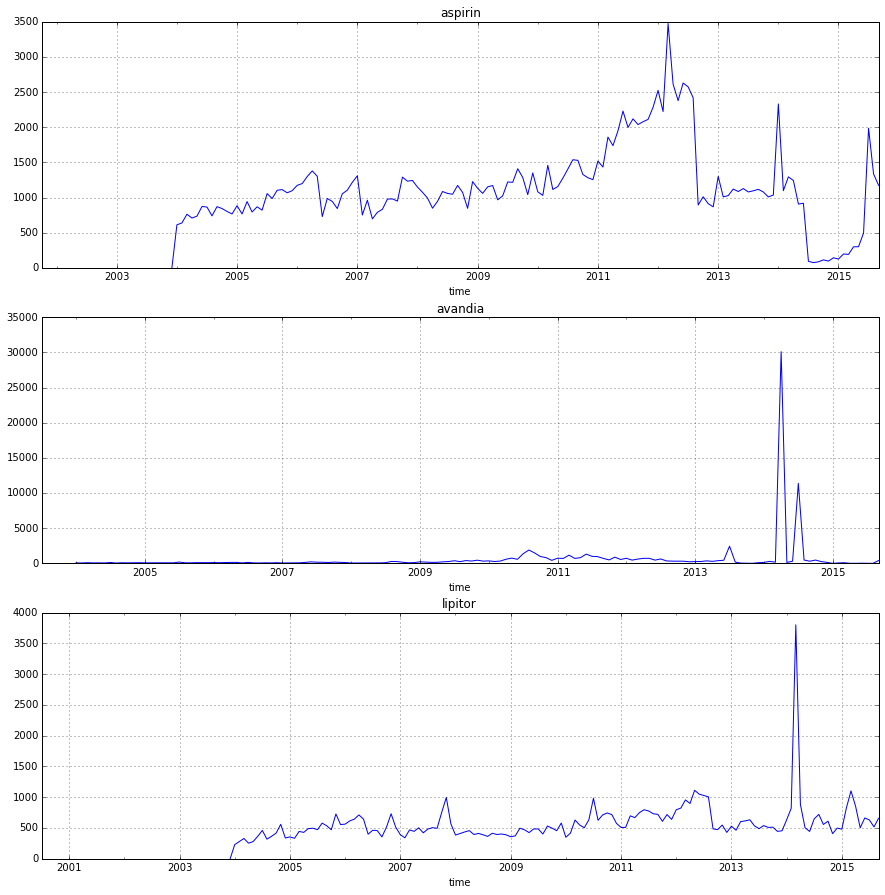

In [145]:
drugs = ['aspirin', 'avandia', 'lipitor']
f = plt.figure(figsize=(15,15))
axidx = 1
for drug in drugs:
    url = 'https://api.fda.gov/drug/event.json?search=patient.drug.openfda.brand_name:"'+drug+'"'+'+AND+serious:1&count=receivedate'
    cols = ['count', 'time']
    df = grab_data(url, cols)
    if isinstance(df, pd.DataFrame):
        df["time"] = [pd.to_datetime(x, '%Y%m%d') for x in df["time"]]
        df = df.set_index(['time'])
        df2 = df.groupby(pd.TimeGrouper("M")).sum()
        ax = f.add_subplot(len(drugs),1,axidx)
        df2.plot(ax = ax, legend=False,sharex=False)
        ax.set_title(drug)
    else:
        print 'request failed'
    axidx += 1


As we can see from the above figure, serious reported adverse events associated with Aspirin vary greatly over time, peaking at mid 2012 and following a decreasing trend since then. However, there are two big surges at the beginning of 2014 and mid of 2015. Avandia and Lipitor, on the other hand, have huge spikes in the numbers of reported adverse events during the beginning of 2014. These perhaps occur at the same time with some disputes or lawsuits on the side effects of the two drugs in clinical studies.

#Figure 2: Major patient reactions reported by selected drugs

We now look at several popular patient reactions seen in the adverse event reports associated with the aforementioned drugs:

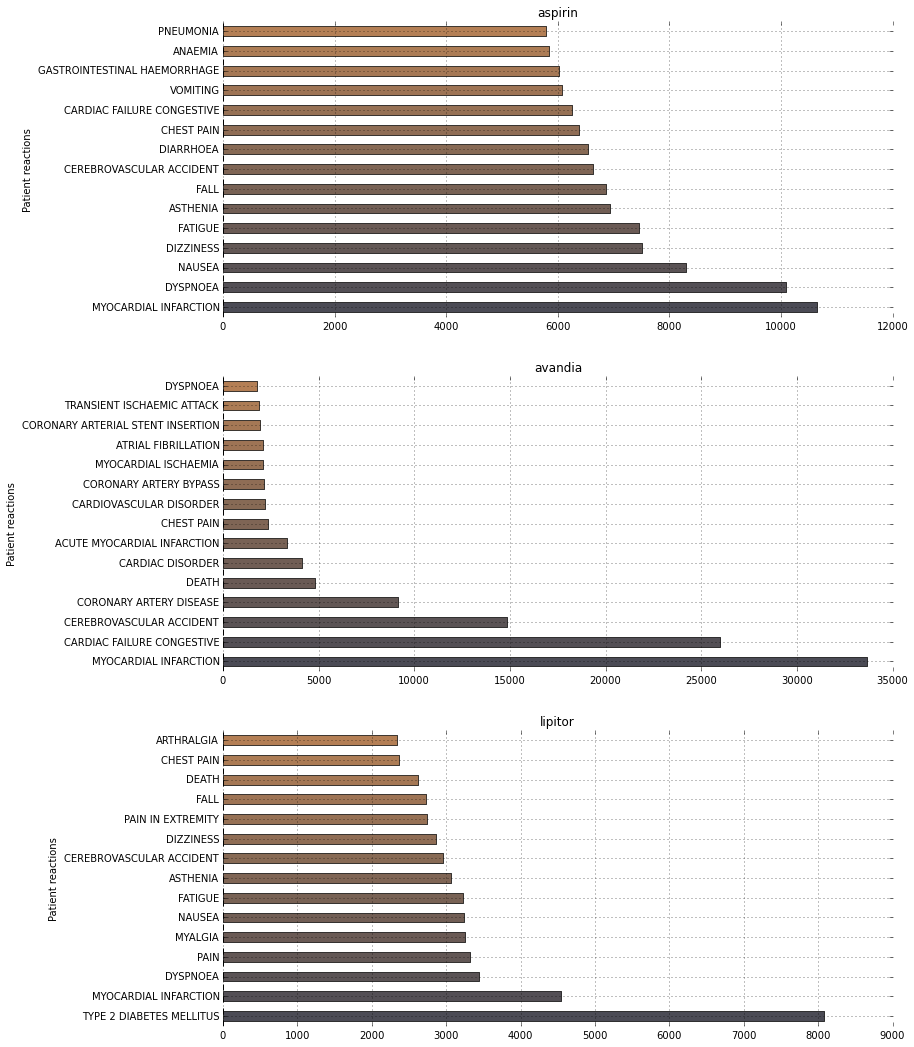

In [146]:
drugs = ['aspirin', 'avandia', 'lipitor']
f = plt.figure(figsize=(12,18))
axidx = 1
for drug in drugs:
    url = 'https://api.fda.gov/drug/event.json?search=serious:1+AND+patient.drug.medicinalproduct:'+drug+'&count=patient.reaction.reactionmeddrapt.exact&limit=15'
    cols = ['count', 'term']
    df = grab_data(url, cols)
    df2 = df.set_index('term')
    # Create a colormap
    customcmap = [(x/24.0,  x/48.0, 0.05) for x in range(len(df2))]
    ax = f.add_subplot(len(drugs),1,axidx)
    ax.set_frame_on(False)
    df2.plot(ax = ax, kind = 'barh', alpha=0.7, x=df2.index, y='count', legend=False, sharex=False, sharey=False, title=drug, color=customcmap)
    ax.set_ylabel('Patient reactions')
    axidx += 1

As we can see, patient reactions varies greatly with the type of drugs being considered. Some of the patient reactions could be good indicator of seriousness of the drug side effects. For example, myocardial infarction is regularly seen in patient reactions in serious adverse event reports associated with Avandia and Lipitor. Hence, one can try to apply multiple regression or classification methods (such as tree-based methods) in order to analyze the effects of such factors (and some other factors such as demographic characteristics, treatment dosage and duration) on an adverse event outcome.